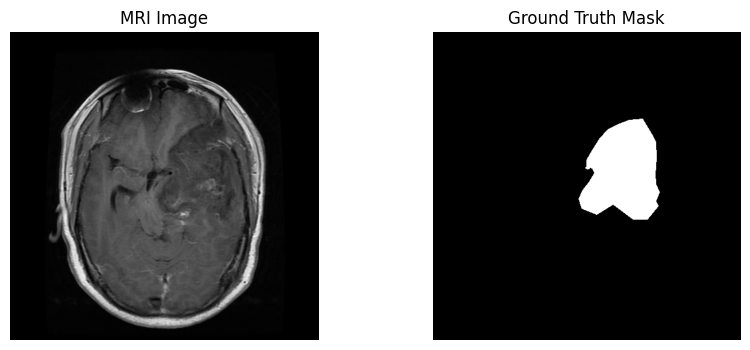

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

image_folder = "/kaggle/input/brisc2025/brisc2025/segmentation_task/train/images"
mask_folder = "/kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks"

image_files = os.listdir(image_folder)

image_path = "/kaggle/input/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_00001_gl_ax_t1.jpg"
mask_path = "/kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks/brisc2025_train_00001_gl_ax_t1.png"

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# convert mask to binary (0 and 1)
mask = (mask > 127).astype(np.uint8)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title("MRI Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.show()


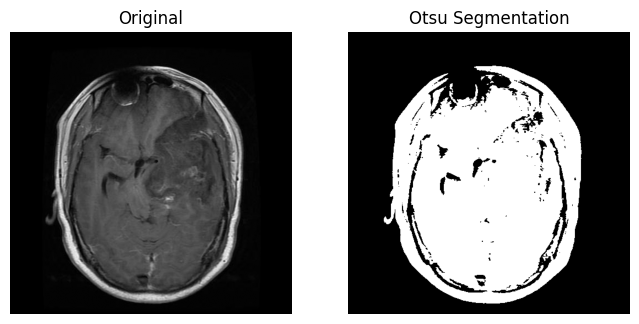

In [2]:
#otsu_threshold..

from skimage.filters import threshold_otsu

otsu_thre = threshold_otsu(image)

otsu_segment  = (image > otsu_thre).astype(np.uint8)

plt.figure(figsize=(8,5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Otsu Segmentation")
plt.imshow(otsu_segment, cmap='gray')
plt.axis('off')

plt.show()


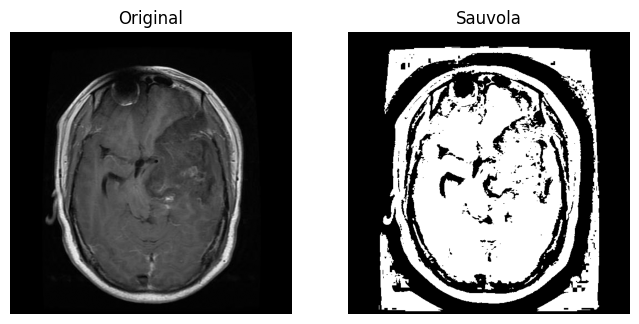

In [3]:
# sauvola threshould..

from skimage.filters import threshold_sauvola

window_size = 51

sauvola_thre = threshold_sauvola(image, window_size = window_size, k=0.2)

sauvola_segment = ( image > sauvola_thre).astype(np.uint8)

plt.figure(figsize=(8,5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Sauvola")
plt.imshow(sauvola_segment, cmap='gray')
plt.axis('off')

plt.show()

**my understanding on k value and window size** 

-> by formula, if k is smaller threshould  will come closer to mean then we may miss small tumor region segmentation. i k is too large i considers very small region and it may leads to false positive

-> if window size too small, it considers very small region too which increases noise. if window size is too large it will miss small tumor region

In [4]:
# functions to calculate dice score and iou
def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2 * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

def jaccard_index(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-8)


**why we have to use (union+ 1e-8)**

--> as it is in ddenominator, if union is zero then overall value becomes undefined. so by add very small value we avoid that mistake 

In [5]:
#appling marphological operation to smoothen the image

kernel = np.ones((3,3), np.uint8)

otsu_clean = cv2.morphologyEx(otsu_segment, cv2.MORPH_CLOSE, kernel)
sauvola_clean = cv2.morphologyEx(sauvola_segment, cv2.MORPH_CLOSE, kernel)


In [6]:
#without morphological operation

dice_otsu = dice_score(mask, otsu_segment)
dice_sauvola = dice_score(mask, sauvola_segment)

jaccard_otsu = jaccard_index(mask, otsu_segment)
jaccard_sauvola = jaccard_index(mask, sauvola_segment)

print("Otsu Dice:", dice_otsu)
print("Sauvola Dice:", dice_sauvola)

print("Otsu Jaccard:", jaccard_otsu)
print("Sauvola Jaccard:", jaccard_sauvola)


Otsu Dice: 0.24002053651647415
Sauvola Dice: 0.1845747998193403
Otsu Jaccard: 0.1363768961493458
Sauvola Jaccard: 0.10167028627837302


In [7]:
#with morphological operation

dice_otsu = dice_score(mask, otsu_clean)
dice_sauvola = dice_score(mask, sauvola_clean)

jaccard_otsu = jaccard_index(mask, otsu_clean)
jaccard_sauvola = jaccard_index(mask, sauvola_clean)

print("Otsu Dice:", dice_otsu)
print("Sauvola Dice:", dice_sauvola)

print("Otsu Jaccard:", jaccard_otsu)
print("Sauvola Jaccard:", jaccard_sauvola)


Otsu Dice: 0.24212810440950946
Sauvola Dice: 0.1892076070843826
Otsu Jaccard: 0.13773933414424133
Sauvola Jaccard: 0.10448884578078724


**no much more difference after morphological operation so, no need to use this operation**


In [8]:
# for overall dataset

dice_otsu_list = []
dice_sauvola_list = []

jaccard_otsu_list = []
jaccard_sauvola_list = []

for name in image_files[:50]:
    
    image_path = os.path.join(image_folder, name)
    
    mask_name = name.replace(".jpg", ".png")  
    mask_path = os.path.join(mask_folder, mask_name)
    
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    mask = (mask > 127).astype(np.uint8)
    
    otsu_threshold = threshold_otsu(image)
    otsu_segment = (image > otsu_threshold).astype(np.uint8)
    
    sauvola_threshold = threshold_sauvola(image, window_size=51, k=0.2)
    sauvola_segment = (image > sauvola_threshold).astype(np.uint8)
    
    
    dice_otsu_list.append(dice_score(mask, otsu_segment))
    dice_sauvola_list.append(dice_score(mask, sauvola_segment))

    jaccard_otsu_list.append(jaccard_index(mask, otsu_segment))
    jaccard_sauvola_list.append(jaccard_index(mask, sauvola_segment))

print("Average Otsu Dice:", np.mean(dice_otsu_list))
print("Average Sauvola Dice:", np.mean(dice_sauvola_list))
print("Average Otsu jaccard:", np.mean(jaccard_otsu_list))
print("Average Sauvola jaccard:", np.mean(jaccard_sauvola_list))


Average Otsu Dice: 0.07543403316777755
Average Sauvola Dice: 0.053706761292899224
Average Otsu jaccard: 0.04063561229637708
Average Sauvola jaccard: 0.028199978188639094


**Conclusion**

In this assignment, tumor segmentation on MRI images was performed using Global Otsu thresholding and Sauvola adaptive thresholding. The experimental results show that Otsu achieved a higher average Dice score (0.07543) and Jaccard index (0.0406) compared to Sauvola (Dice: 0.0406, Jaccard: 0.0282).

Although both methods produced low segmentation accuracy, Otsu performed relatively better than Sauvola on this dataset. This indicates that adaptive local thresholding does not necessarily improve performance for complex MRI tumor images. The results also highlight the limitations of intensity-based thresholding methods for medical image segmentation.